# SHAP interactions between YEAR and STROKE TEAM
Using first k-fold split

### Plain English summary

Here we will look at the interaction between the features Year and Stroke team. We saw that feature Year is only selected in the feature list if stroke team is an option too.

SHAP interactions can not be calculated for multiclass classification. Instead we use the set of 6 binary models as trained in notebook 080. For these models we convert the target feature (disability_discharge) into a binary feature by predicting whether a patient is at least as well as mRS0, mRS1, mRS2, mRS3, mRS4, mRS5.

This gives us a set of six models.  

Use just first kfold as seen performance of model is consistent across the 5 data divisions.

This model includes 8 features "prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known", "year"\

### Model and data

Model: XGBoost classifier (multiclass classification) [trained in this notebook]\
Target feature: Disability at discharge is t least as well as each mRS level (binary feature)\
Input features: 8 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known, year)\
Kfold split: The first kfold

### Aims


### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

Orinigally this code was in notebooks 050-055 and 060-065 (for 6 and 7 features as input, and a separate notebook per threshold value, and both SHAP and SHAP interaction code together). Now 080 has the SHAP values for each binary model, and 090 has the SHAP interactions for each binary model.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import copy

import time
import datetime

Report the time duration to run notebook

In [2]:
start_time = time.time()

Use just the first k-fold split

In [3]:
k = 0

# Values to use as the threshold <= n in order to divide the target feature
list_binary_thresholds = [0, 1, 2, 3, 4, 5]

n_binary_models = len(list_binary_thresholds)

Select the features for the model

In [4]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "any_afib_diagnosis", 
                     "onset_to_thrombolysis_time", "precise_onset_known", 
                     "year"]
n_features = len(selected_features)

target_feature = 'discharge_disability'

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = (f'xgb_{n_features}_features_1kfold'
                       f'_binary')
    notebook: str = '090_'

paths = Paths()

Create output folders if needed

In [6]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Import the data for the first kfold split.

Extract the features for the model.

In [7]:
filename = os.path.join(paths.data_read_path, ('03_train_' + str(k) + '.csv'))
train_data = pd.read_csv(filename)
X_train = train_data[selected_features]
y_train = train_data[target_feature]

filename = os.path.join(paths.data_read_path, ('03_test_' + str(k) + '.csv'))
test_data = pd.read_csv(filename)
X_test = test_data[selected_features]
y_test = test_data[target_feature]

One hot the categorical features
Convert some categorical features to one hot encoded features.

Define a function

In [8]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix=prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Keep copy of original data, with 'Stroke team' not one-hot encoded

In [9]:
test_stroke_team = X_test["stroke_team"].values
train_stroke_team = X_train["stroke_team"].values
test_data_orig = test_data.copy(deep=True)
train_data_orig = train_data.copy(deep=True)

For both train and test dataset, convert "stroke_team" feature to one hot encoded.

In [10]:
feature = "stroke_team"
prefix = "team"
if feature in list(X_train):
    X_train = convert_feature_to_one_hot(X_train, feature, prefix)
    X_test = convert_feature_to_one_hot(X_test, feature, prefix)

Feature names with one hot encoding

In [11]:
feature_names_ohe = list(X_train)
n_features_ohe = len(feature_names_ohe)

In [12]:
print(f"There are {len(selected_features)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features_ohe} features (after one-hot encoding)")

There are 8 original features (before one-hot encoding)
There are 125 features (after one-hot encoding)


Create a dataframe containing each of the target features for the different threshold values

In [13]:
def create_df_of_binary_target_features(target_feature_data, binary_thresholds):
    """ 
    Given a feature, return a dataframe of all of the different binary versions 
    depending on the threshold used

    Args:
        data [dataframe]: patient feature values
        target_feature [string]: feature name of target feature
        binary_thresholds [list]: list of thresholds to use for each version of 
                    a binary target feature

    Return:
        df [dataframe]: row per instance, column per threshold. Containing 
        feature values for patients with binary representation of the target 
        feature, based on the threshold value 
    
    """    
    df = pd.DataFrame()

    for threshold in binary_thresholds:
        binary_target_feature_name = f'{target_feature}_bin_{threshold}'

        # For the new feature, set all to 0    
        df[binary_target_feature_name] = 0

        # Then set to 1 those patients that are the threshold value or less
        df[binary_target_feature_name] = (
                                    (target_feature_data <= threshold) * 1)
        
    return(df)

Create dataframe of the binary target features

In [14]:
df_all_y_bin_train = create_df_of_binary_target_features(y_train, 
                                                         list_binary_thresholds)
df_all_y_bin_test = create_df_of_binary_target_features(y_test, 
                                                        list_binary_thresholds)

Plot barchart of proportion in each class for each of the thresholds

In [15]:
def plot_barchart(df_bin_target_feature):
    """
    
    Args:
        df_bin_target_feature [dataframe]: A column per target feature using a 
                      different threshold for a binary representation 
        
    Return:
        None    
    """  
    
    count_0 = []
    count_1 = []
    max_accuracy_if_majority = []
    n_instances = df_bin_target_feature.shape[0]
    columns = df_bin_target_feature.columns

    for col in columns:
        df_bin_target_feature[col]
        n_zeros = (df_bin_target_feature[col] == 0).sum()
        count_0.append(n_zeros)
        n_ones = (df_bin_target_feature[col] == 1).sum()
        count_1.append(n_ones)

        # If model predicted every instance was the majority class, what would 
        # the accuracy be
        max_accuracy = max(n_zeros/n_instances, n_ones/n_instances)
        max_accuracy_if_majority.append(round(max_accuracy*100, 1))

    # create data
    x = np.arange(len(count_1)).tolist()

    x_ticks = []
    for i in x:
        x_ticks.append(f"{i}\n[{max_accuracy_if_majority[i]}%]") 

    # plot bars in stack manner
    plt.bar(x, count_1, bottom=count_0, color='b', label="Yes")
    plt.bar(x, count_0, color='r', label="No")
    plt.xlabel("mRS threshold for being 'at least as well as'\n[accuracy if "
               "all instances classified as majority class]")
    plt.ylabel("Count of patients")
    plt.xticks(x, x_ticks)
    plt.legend(bbox_to_anchor=(1.03, 1.0))
    plt.title("Count of patients in each binary category, for each threshold "
              "level (test dataset)")
    plt.show()
    return(max_accuracy_if_majority)

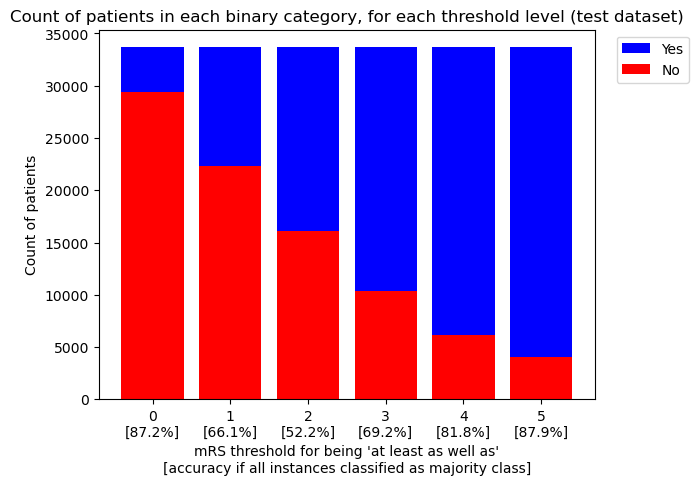

In [16]:
max_accuracy_if_majority = plot_barchart(df_all_y_bin_test)

Define function to load XGBoost model

In [17]:
def load_xgb_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else give error message.

    Args:
        filename [string]: where xgboost model is saved
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        print("Run notebook 080 to train the XGBoost models used in this "
              "notebook")
    return(model)

Define function to calculate preditions from model

In [18]:
def calculate_predicted_probabilities(model, X_data):
    """ 
    Given a model and input data, return the models probability and prediction
    for each instance.
    
    Args:
        model [xgboost classifier object]: trained model
        X_data [dataframe]: input features for model

    Return:
        y_probs [array]: the probability of being in each target feature class
        y_pred [array]: the prediction (the class with the largest probability)
    """

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_data)

    # Get and store predicted class
    y_pred = model.predict(X_data)

    return(y_probs, y_pred)

Create function to return SHAP values extended

In [19]:
def load_shap_extended(filename):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        filename [string]: name of file containing SHAP extended data
        model [xgboost classification model object]: xgboost object
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [object]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        print("Run notebook 080 to train the XGBoost models used in this "
              "notebook")               
    return(shap_values_extended)

### Calculate SHAP interaction values
A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect), for each instance. The SHAP value for a feature is the sum of it's pair-wise feature interactions.

We will use the TreeExplainer (from the shap library: https://shap.readthedocs.io/en/latest/index.html) to calculate the SHAP interaction values.

'Raw' SHAP interaction values from XGBoost model are log odds ratios.

Either load from pickle (if file exists), or calculate.

In [20]:
def calculate_shap_interactions(filename, model, X_test):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        model [xgboost classification model object]: xgboost object
        k [integer]: kfold number
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [dictionary]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """
# Load SHAP interation values, or calculate from explainer

    file_exists = exists(filename)

    if file_exists:
        # Load SHAP interaction
        with open(filename, 'rb') as filehandler:
            shap_interactions = pickle.load(filehandler)
    else:
        explainer = shap.TreeExplainer(model)

        # Calculate SHAP interaction values
        shap_interactions = explainer.shap_interaction_values(X_test)
        
        # Save using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_interactions, filehandler)
    
    return(shap_interactions)

Code to setup data per binary threshold, fit model and analyse performance

In [21]:
y_pred_binary = []
y_probs_binary = []
list_model = []
list_shap_values_extended = []
list_shap_interactions = []

# Include the new binary feature we calculate (replaces the multiclass feature)
for binary_threshold in list_binary_thresholds:
    print(f"Model using binary threshold {binary_threshold}")

    # Set up the target feature name for this threshold
    binary_target_feature_name = f'{target_feature}_bin_{binary_threshold}'

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            ('080_' + paths.model_text + 
                             str(binary_threshold) + '.p'))

    # Get target feature for this threshold
    y_bin_train = df_all_y_bin_train[binary_target_feature_name]

    ## Fit XGBoost model
    model = load_xgb_model(filename)
    list_model.append(model)
    # Store predictions for test dataset
    (y_probs, y_pred) = calculate_predicted_probabilities(model, X_test)
    y_pred_binary.append(y_pred)
    y_probs_binary.append(y_probs[:,1])
    
    # Get ROC AUC
    y_bin_test = df_all_y_bin_test[binary_target_feature_name]
    fpr, tpr, thresholds = roc_curve(y_bin_test, y_probs[:,1])
    roc_auc = auc(fpr, tpr)

    # Calculate error
    y_error = y_bin_test - y_pred
    accuracy = np.mean(y_error==0)

    # Get and store feature importances
    feature_importance = model.feature_importances_

    # SHAP values extended
    # Set filename
    filename = os.path.join(paths.data_save_path, 
                        ('080_' + paths.model_text + 
                         str(binary_threshold) + '_shap_values_extended.p'))

    # Load SHAP extended
    shap_values_extended = load_shap_extended(filename)
    list_shap_values_extended.append(shap_values_extended)

    # SHAP interactions
    # Set filename
    filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + paths.model_text + 
                         str(binary_threshold) + '_shap_interactions.p'))

    # Calculate or load SHAP interactions
    shap_interactions = calculate_shap_interactions(filename, model, X_test)
    list_shap_interactions.append(shap_interactions)
    
    print (f'Accuracy: {accuracy:0.3f} ')
    print (f'ROCAUC: {roc_auc:0.3f}')
    print (f'(Accuracy if categorise all as majority class: ' +
           f'{max_accuracy_if_majority[binary_threshold]:0.3f})')
    print()

Model using binary threshold 0


Accuracy: 0.884 
ROCAUC: 0.859
(Accuracy if categorise all as majority class: 87.200)

Model using binary threshold 1
Accuracy: 0.780 
ROCAUC: 0.854
(Accuracy if categorise all as majority class: 66.100)

Model using binary threshold 2
Accuracy: 0.801 
ROCAUC: 0.877
(Accuracy if categorise all as majority class: 52.200)

Model using binary threshold 3
Accuracy: 0.841 
ROCAUC: 0.889
(Accuracy if categorise all as majority class: 69.200)

Model using binary threshold 4
Accuracy: 0.880 
ROCAUC: 0.891
(Accuracy if categorise all as majority class: 81.800)

Model using binary threshold 5
Accuracy: 0.895 
ROCAUC: 0.867
(Accuracy if categorise all as majority class: 87.900)



Get column index of the individual hosptials

In [22]:
# Get list of hospital one hot encoded column titles
hospital_names_ohe = X_test.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column index for these hospital column titles
hospital_columns_index = [X_test.columns.get_loc(col) for col in hospital_names_ohe]

# Create dictionary of column index for these hospital column titles
dict_hosp_index={}
for col in hospital_names_ohe:
    dict_hosp_index[f"{col}"] = X_test.columns.get_loc(col)

Get the index for the feature "year"

In [23]:
# Store the column index for the year feature
year_index = X_test.columns.get_loc("year")

Define function

In [24]:
def create_df_one_hot_encoded_hosp_features(shap_values, 
                hospital_columns_index, hospital_names):
    """
    Extract the SHAP values for the hospital one hot encoded features.

    Args:
        shap_values [object]: with three parts 
                                      (.values, .basevalues, .data)
        hospital_columns_index [list]: column indices for the one hot encoded
                                       hospital features
        hospital_names [list]: list of the hospital names

    Return:
        df [dataframe]: SHAP values, row per instance, column per hospital one 
                        hot encoded feature
        
    """    
    # Use this index list to access the hosptial shap values (as array)
    hosp_shap_values = shap_values[:,hospital_columns_index]

    # Put in dataframe with hospital as column title
    df = pd.DataFrame(hosp_shap_values, columns=hospital_names)

    return(df)


In [25]:
def add_columns_to_df(df, stroke_team_values):

    """

    Add these columns:
    # Stroke team instance attended
    # contribution from all the hospital features
    # contribution from attending the hospital
    # contribution from not attending the rest

    Args:
        df []:
        stroke_team_values []:

    Return:
        df [dataframe]:
        
    """  


    # Include Stroke team that each instance attended
    df["Stroke team"] = stroke_team_values

    # Store the sum of the SHAP values (for all of the hospital features)
    df["all_stroke_teams"] = (df.sum(axis=1))

    # Initialise lists for 
    #   1) SHAP value for attended hospital 
    #   2) SHAP value for the sum of the rest of the hospitals
    attended_hospital = []
    not_attend_these_hospitals = []

    # For each patient
    for index, row in df.iterrows():

        # Get stroke team attended
        stroke_team = row["Stroke team"]
        
        # Get SHAP value for the stroke team attended
        attended_hospital.append(row[stroke_team])

        # Calculate sum of SHAP values for the stroke teams not attend 
        sum_rest = row["all_stroke_teams"] - row[stroke_team]
        not_attend_these_hospitals.append(sum_rest)

    # Store two new columns in dataframe
    df["attended_stroke_team"] = attended_hospital
    df["not_attended_stroke_teams"] = (not_attend_these_hospitals)
                    
    # View preview
    return(df)

In [26]:
def set_box_color(bp, color):
    """
    bp [boxplot object]
    color [Hex Color Codes]
    """
    
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['means'], color=color)

    return()

In [27]:
def create_box_plot_population_level(df_hosp_shap_values,
                                     df_hosp_shap_main_effects,
                                     df_hosp_year_shap_interactions,
                                     binary_threshold):
    
    """ 
    ### Create boxplot (range of SHAP values and SHAP main effect across 132 hospitals)
Analyse the range of SHAP values and SHAP main effect values for the one-hot encoded hospital features. Show as two populations: the attended hospital, the sum of the hospitals not attended

To create a grouped boxplot, used code from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

To define HEX colour codes use http://colorbrewer2.org/

    
    """

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ticks = ["Attended hospital", "Not attend these hospitals"]

    # SHAP value for plot
    # A list of two lists, the values in each list create a box on the plot
    plot_data_sv = [df_hosp_shap_values["attended_stroke_team"], 
                    df_hosp_shap_values["not_attended_stroke_teams"]]
    bp_sv = plt.boxplot(plot_data_sv, 
                    positions=np.array(range(len(plot_data_sv)))*2.0-0.7, 
                    sym='', whis=99999, widths=0.3)
    set_box_color(bp_sv, '#0bbed8')

    # SHAP main effect for plot
    # A list of two lists, the values in each list create a box on the plot
    plot_data_me = [df_hosp_shap_main_effects["attended_stroke_team"], 
                    df_hosp_shap_main_effects["not_attended_stroke_teams"]]
    bp_me = plt.boxplot(plot_data_me, 
                    positions=np.array(range(len(plot_data_me)))*2.0, 
                    sym='', whis=99999, widths=0.3)
    set_box_color(bp_me, '#D7191C')

    # SHAP interaction with year for plot
    # A list of two lists, the values in each list create a box on the plot
    plot_data_yhi = [df_hosp_year_shap_interactions["attended_stroke_team"], 
                    df_hosp_year_shap_interactions["not_attended_stroke_teams"]]
    bp_yhi = plt.boxplot(plot_data_yhi, 
                    positions=np.array(range(len(plot_data_yhi)))*2.0+0.7, 
                    sym='', whis=99999, widths=0.3)
    set_box_color(bp_yhi, '#314451')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#0bbed8', label='SHAP value')
    plt.plot([], c='#D7191C', label='SHAP main effect')
    plt.plot([], c='#314451', label='SHAP interaction hospital-year')
    plt.legend()

    # X axis
    plt.xticks(range(0, len(ticks) * 2, 2), ticks, size=13)
    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()

    # Add line at Shap = 0
    ax.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 

    title = ("The range of SHAP (values, main effect, or interaction with year)\n"
            "for the one-hot encoded hospital features\ndepending on whether "
            "attend the hospital, or not.\nModel predicting whether patient "
            "disability at threshold is at least as well as "
            f"mRS{binary_threshold}")
    plt.title(title, size=15)
    plt.ylabel('SHAP (values, main effect or interaction with year)\nof one-hot '
            'encoded feature', size=13)
    plt.xlabel('Patient population', size=13)

    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                            paths.model_text + '_hosp_shap_value_main_effect_' + 
                            'interaction_attend_vs_notattend_boxplot_threshold'
                            + f'{binary_threshold}.jpg'))
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()

Results for one-hot encoded hospital feature SHAP values (for each threshold model)

Create three dataframes.
1) SHAP value for the hospital attended
2) SHAP main effect value for the hospital attended
3) SHAP interaction value for the hospital attended with year feature

SHAP interaction values have a matrix of values (per pair of features) per instance.

In this case, each of the 33670 instances has a 125x125 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).
Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

shap_interactions[instance,feature,feature]

### Extract SHAP interaction values for year with hospital one hot encoded features

Features are in the same order in shap_interaction as they are in the original dataset. Use this fact to extract the SHAP interaction between year and each one-hot encoded hospital features.

Create a dataframe containing the SHAP values: an instance per row, and an interaction with each one-hot encoded hospital feature per column.

### Extract SHAP main effect for hospital one hot encoded features

Features are in the same order in shap_interaction as they are in the original dataset. Use this fact to extract the SHAP main effect values for the one-hot encoded hospital features.

Create a dataframe containing the SHAP main effect values: an instance per row, and a one-hot encoded hospital feature per column.

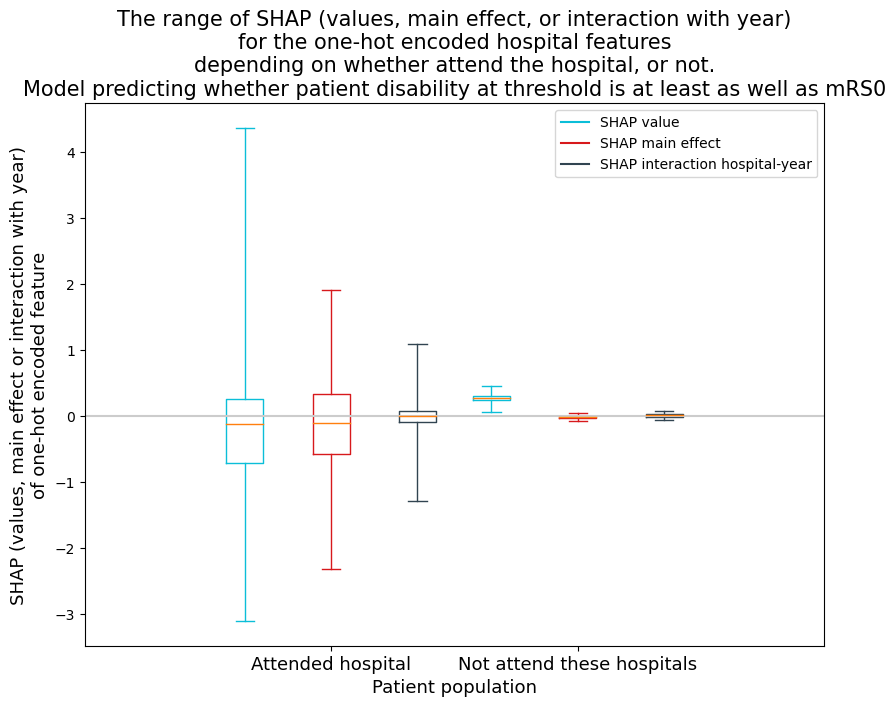

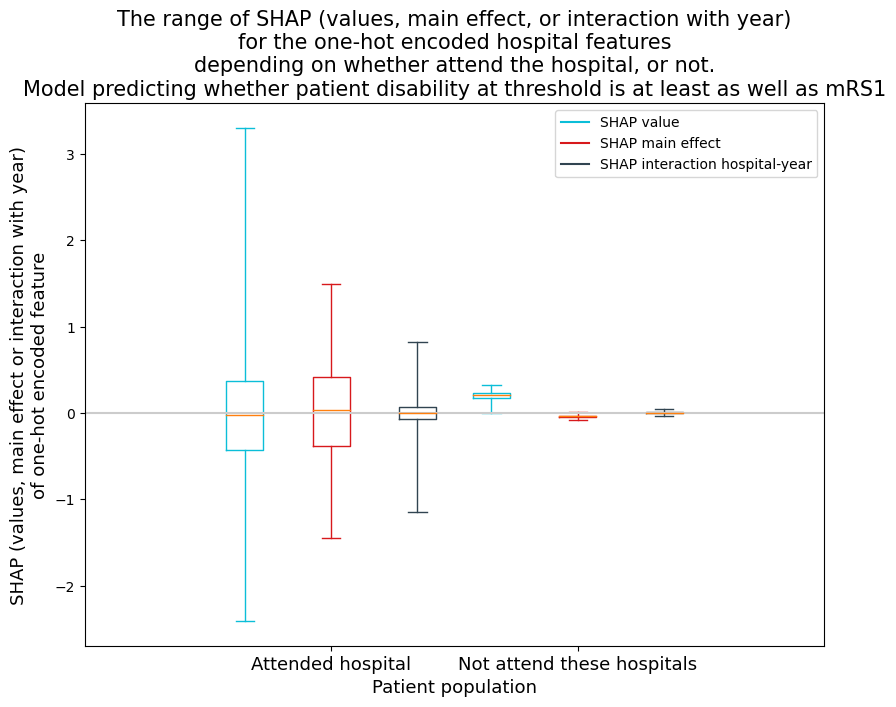

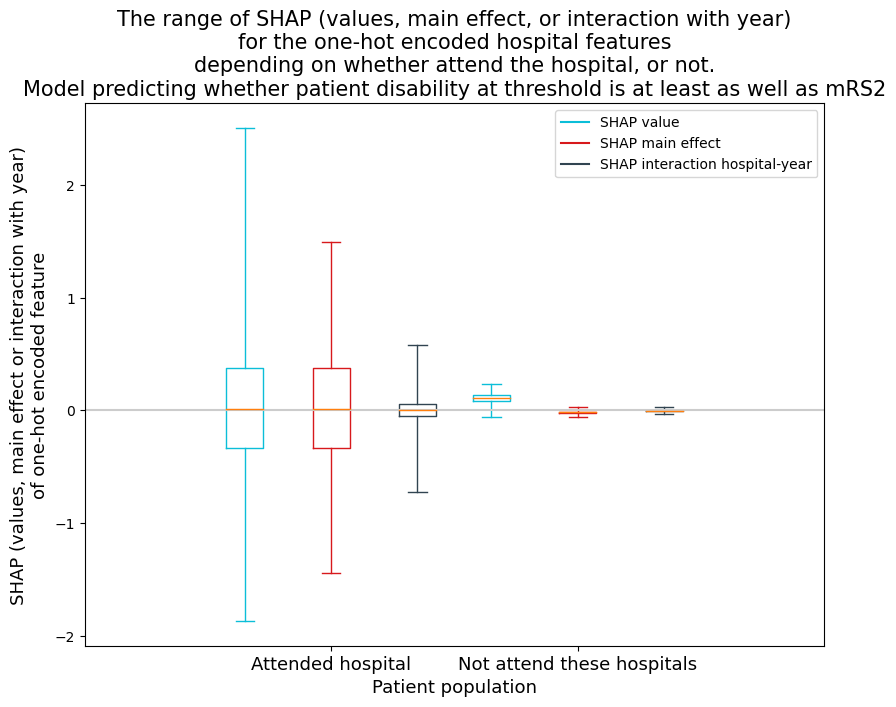

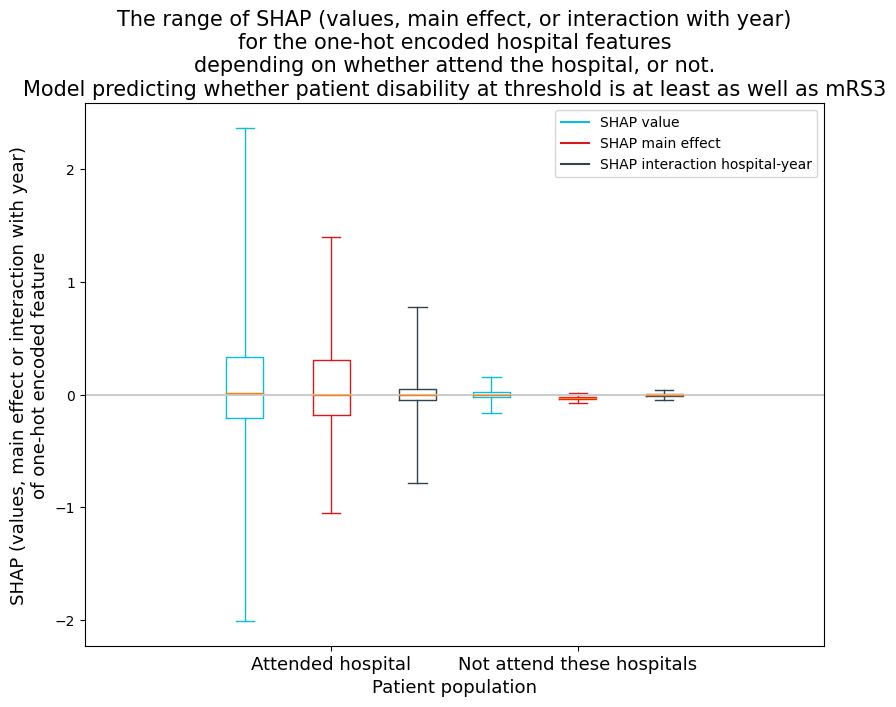

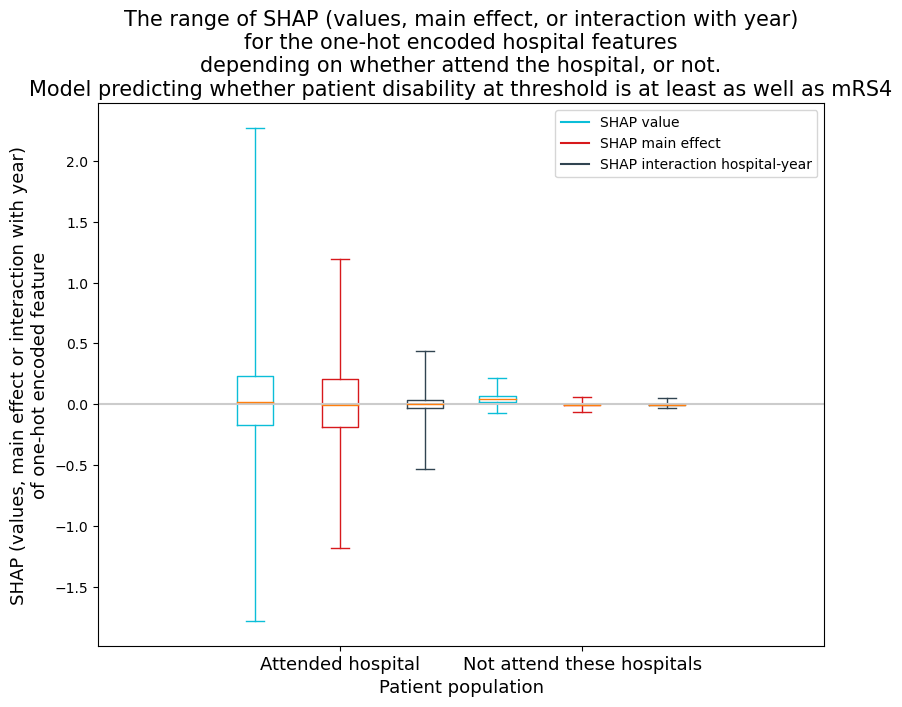

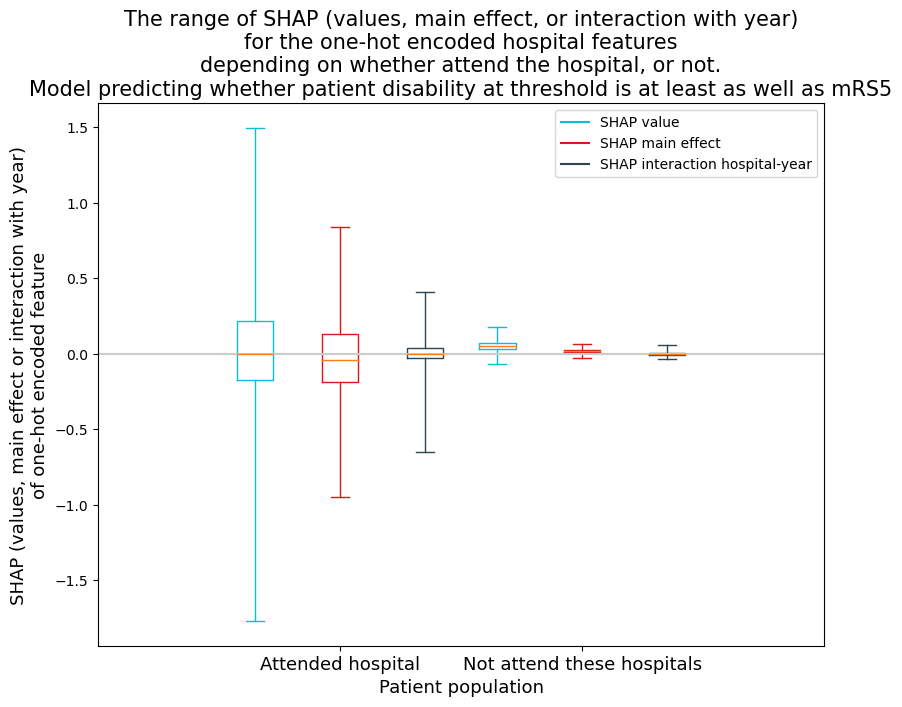

In [28]:
# For each model, get the SHAP and SHAP interaction values, create three
# dataframes, with values per patient: 
# 1) SHAP value for the hospital attended
# 2) SHAP main effect value for the hospital attended
# 3) SHAP interaction value for the hospital attended with year feature

list_df_hosp_shap_values = []
list_df_hosp_year_shap_interactions = []
list_df_hosp_shap_main_effects = []

for binary_threshold in list_binary_thresholds:
    # Format the SHAP values
    df_hosp_shap_values = create_df_one_hot_encoded_hosp_features(
                    list_shap_values_extended[binary_threshold].values, 
                    hospital_columns_index, hospital_names)

    # Add columns, extract the data for the attended hospital per patient
    df_hosp_shap_values = add_columns_to_df(
                    df_hosp_shap_values, 
                    test_stroke_team)
    
    list_df_hosp_shap_values.append(df_hosp_shap_values)

    # Get SHAP interaction for threshold model
    shap_interactions = list_shap_interactions[binary_threshold]

    # Format the SHAP interaction values 
    # Each hospital one hot encoded feature (per column) value is interaction 
    # with Year
    df_hosp_year_shap_interactions = pd.DataFrame(
                    shap_interactions[:, year_index, hospital_columns_index], 
                    columns=hospital_names)
    
    # Add columns, extract the data for the attended hospital per patient
    df_hosp_year_shap_interactions = add_columns_to_df(
                    df_hosp_year_shap_interactions, 
                    test_stroke_team)
    
    list_df_hosp_year_shap_interactions.append(df_hosp_year_shap_interactions)

    # Format the SHAP main effect values 
    hosp_shap_main_effects = []

    # Use index list to access the hosptial shap values (as array) in the loop below
    for i in range(shap_interactions.shape[0]):
        # Get the main effect value for each of the features
        main_effects = np.diagonal(shap_interactions[i])
        hosp_shap_main_effects.append(main_effects[hospital_columns_index])
        
    # Put in dataframe with hospital as column title
    df_hosp_shap_main_effects = pd.DataFrame(
                    hosp_shap_main_effects, 
                    columns=hospital_names)

    # Add columns, extract the data for the attended hospital per patient
    df_hosp_shap_main_effects = add_columns_to_df(
                    df_hosp_shap_main_effects, 
                    test_stroke_team)
    
    list_df_hosp_shap_main_effects.append(df_hosp_shap_main_effects)

    create_box_plot_population_level(df_hosp_shap_values,
                                     df_hosp_shap_main_effects,
                                     df_hosp_year_shap_interactions,
                                     binary_threshold)

# Interaction between ST and Year

Repeat above Boxplot but with individual hospital, and include the SHAP interaction between Year and StrokeTeamas a third box per hospital.

Create boxplot (range of SHAP values and SHAP main effect within each 132 hospitals)
Create a boxplot to show the range of SHAP values and SHAP main effect values for each individual one-hot encoded hospital feature.

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of mean SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the mean SHAP main effect, and mean SHAP values for each hosptial (for those instances that attended the hospital)

Want to add admission figures to xlabel in boxplot. Create dataframe with admissions and thrombolysis rate per stroke team (index)

In [29]:
data_train_test = test_data_orig.append(train_data_orig)
data_train_test["thrombolysis"] = (data_train_test["onset_to_thrombolysis_time"] > -100) * 1

# Get list of unique stroke team names
unique_stroketeams_list = list(set(data_train_test["stroke_team"]))

# Calculate admissions to each team
admissions = [((data_train_test["stroke_team"]) == s).sum() for s in unique_stroketeams_list]

# Create dataframe with stroke team and admissions
df_stroketeam_ivt_adms = pd.DataFrame(unique_stroketeams_list, 
                                      columns=["Stroke team"])
df_stroketeam_ivt_adms["Admissions"] = admissions
df_stroketeam_ivt_adms.set_index("Stroke team", inplace=True)
df_stroketeam_ivt_adms.sort_values("Admissions", ascending=True, inplace=True)

# Calculate IVT rate per hosptial
hosp_ivt_rate = data_train_test.groupby(by=["stroke_team"]).mean()["thrombolysis"]

# Join IVT rate with admissions per hosptial
df_stroketeam_ivt_adms = df_stroketeam_ivt_adms.join(hosp_ivt_rate)
df_stroketeam_ivt_adms.columns = ["Admissions","Thrombolysis"]
df_stroketeam_ivt_adms

Admissions  Thrombolysis
Stroke team                                                         
University Hospitals Dorset Stroke Service         358      0.189944
Warwick Hospital                                   358      0.058659
Bronglais Hospital                                 363      0.325069
Weston General Hospital                            461      0.173536
West Wales General                                 465      0.283871
...                                                ...           ...
Stepping Hill Hospital                            2774      0.175919
University College Hospital HASU                  2902      0.152653
Queen Alexandra Hospital Portsmouth               3041      0.255508
Princess Royal Hospital Telford                   3050      0.182951
Salford Royal Hospital                            4559      0.096293

[118 rows x 2 columns]

In [30]:
def shap_descriptive_stats(hospital_names, df_hosp_shap, prefix_text):
    """
    For a set of columns (those contained in "hospital_names"), take only the
    values which represented a hospital attended (using a mask from column 
    "stroke team". Return the descripive values of the IQR for the attended 
    hospital values (in a dataframe with hospital as row and each IQR as a 
    column.
    
    hospital_names [list]: The list of unique hospital names
    df_hosp_shap [DataFrame]: Contains a value per hospital (column) per 
                              patient (row)
    prefix_text [string]: Define what values are in the dataframe
    return [DataFrame]: A hospital per row and each IQR as a column
    """
    
    # Create list of values (one per hospital) for those instances that attend 
    #   the hospital. Store the IQR for all the patients that attend the
    #   hospital
    attend_stroketeam_min = []
    attend_stroketeam_q1 = []
    attend_stroketeam_mean = []
    attend_stroketeam_q3 = []
    attend_stroketeam_max = []
    
    for h in hospital_names:
        mask = df_hosp_shap['Stroke team'] == h
        data_stroke_team = df_hosp_shap[h][mask]
        q1, q3 = np.percentile(data_stroke_team, [25,75])
        attend_stroketeam_min.append(data_stroke_team.min())
        attend_stroketeam_q1.append(q1)
        attend_stroketeam_mean.append(data_stroke_team.mean())
        attend_stroketeam_q3.append(q3)
        attend_stroketeam_max.append(data_stroke_team.max())

    # Create dataframe with six columns (hospital and descriptive stats)
    df = pd.DataFrame(hospital_names, columns=[f"hospital_{prefix_text}"])
    df[f"shap_min_{prefix_text}"] = attend_stroketeam_min
    df[f"shap_q1_{prefix_text}"] = attend_stroketeam_q1
    df[f"shap_mean_{prefix_text}"] = attend_stroketeam_mean
    df[f"shap_q3_{prefix_text}"] = attend_stroketeam_q3
    df[f"shap_max_{prefix_text}"] = attend_stroketeam_max
    
    return(df)

Define function to create data for boxplot

In [31]:
def create_data_for_hosptial_level_boxplot(hospital_order, 
                                           df_hosp_shap_main_effects, 
                                           df_hosp_shap_values, 
                                           df_hosp_year_shap_interactions,
                                           df_stroketeam_ivt_adms):

    """

    hospital_order []: Go through order of hospital in Dataframe (ordered on mean SHAP main effect)

    """
    # 

        
    # Initiate lists 
    # 1) SHAP main effect (one per hospital) for instances that attend stroke team
    # 2) SHAP value (one per hospital) for instances that attend stroke team
    # 2) SHAP interaction with year (one per hospital) for instances that attend stroke team
    me_attend_stroketeam_groups_ordered = []
    sv_attend_stroketeam_groups_ordered = []    
    ysi_attend_stroketeam_groups_ordered = []    

    # Initiate lists 
    # 1) SHAP main effect (one per hospital) for instances that don't attend stroke 
    #    team
    # 2) SHAP value (one per hospital) for instances that don't attend stroke team
    # 3) SHAP interaction with year (one per hospital) for instances that don't attend stroke team
    me_not_attend_stroketeam_groups_ordered = []
    sv_not_attend_stroketeam_groups_ordered = []
    ysi_not_attend_stroketeam_groups_ordered = []

    # Initiate list for xlabels for boxplot "stroke team name (admissions)"
    xlabel = []

    # Through hospital in defined order (as determined above)
    for h in hospital_order:
        # Attend
        mask = df_hosp_shap_main_effects['Stroke team'] == h
        me_attend_stroketeam_groups_ordered.append(
                                                df_hosp_shap_main_effects[h][mask])
        sv_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
        ysi_attend_stroketeam_groups_ordered.append(df_hosp_year_shap_interactions[h][mask])
        
        # Not attend
        mask = df_hosp_shap_main_effects['Stroke team'] != h
        me_not_attend_stroketeam_groups_ordered.append(
                                                df_hosp_shap_main_effects[h][mask])
        sv_not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
        ysi_not_attend_stroketeam_groups_ordered.append(df_hosp_year_shap_interactions[h][mask])
        
        # Label
        ivt_rate = int(df_stroketeam_ivt_adms['Thrombolysis'].loc[h] * 100)
        xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[h]}, "
                    f"{ivt_rate}%)")
        
    return(me_attend_stroketeam_groups_ordered, 
        sv_attend_stroketeam_groups_ordered,
        ysi_attend_stroketeam_groups_ordered, 
        me_not_attend_stroketeam_groups_ordered,
        sv_not_attend_stroketeam_groups_ordered, 
        ysi_not_attend_stroketeam_groups_ordered, 
        xlabel)

Define function to plot boxplot of hospital attended level

Resource for using overall y min and max of both datasets on the 4 plots so have the same range 
https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.

In [32]:
def create_box_plot_attended_hosptial_level(sv_attend_stroketeam_groups_ordered,
                                     me_attend_stroketeam_groups_ordered,
                                     ysi_attend_stroketeam_groups_ordered, 
                                     xlabel, binary_threshold):

    # Plot 34 hospitals on each figure to aid visually
    n_hospitals = len(hospital_names_ohe)

    # To group the hospitals into 30 per subplot
    st = 0
    ed = 30
    inc = ed
    max_size = n_hospitals
    n_subplots = int(round(n_hospitals/ed,0))

    # Use overall y min & max of both datasets on the 4 plots so have same range
    ymin = min(min(sv_attend_stroketeam_groups_ordered, key=min))
    ymax = max(max(sv_attend_stroketeam_groups_ordered, key=max))

    # Adjust min and max to accommodate some wriggle room
    yrange = ymax - ymin
    ymin = ymin - yrange/50
    ymax = ymax + yrange/50

    # Create figure
    fig = plt.figure(figsize=(15,45))

    fig.suptitle(f"Shows the range of contributions to the prediction that a "
                 f"patient will be at least as well as mRS{binary_threshold} "
                 f"from this hospital, when patients attend this hospital")

    # Create four subplots (divide the 132 hospitals across these to ai visability)
    for subplot in range(n_subplots):
        ax = fig.add_subplot(n_subplots,1,subplot+1)
        
        # The contribution from this hospital when patients do not attend this
        #   hospital
        ticks = xlabel[st:ed]
        
        pos_sv = np.array(range(
                        len(sv_attend_stroketeam_groups_ordered[st:ed])))*2.0-0.7
        bp_sv = plt.boxplot(sv_attend_stroketeam_groups_ordered[st:ed], 
                            positions=pos_sv, sym='', whis=99999, widths=0.3)
        
        pos_me = np.array(range(len(
                            me_attend_stroketeam_groups_ordered[st:ed])))*2.0
        bp_me = plt.boxplot(me_attend_stroketeam_groups_ordered[st:ed], 
                            positions=pos_me, sym='', whis=99999, widths=0.3)

        pos_ysi = np.array(range(len(
                            ysi_attend_stroketeam_groups_ordered[st:ed])))*2.0+0.7
        bp_ysi = plt.boxplot(ysi_attend_stroketeam_groups_ordered[st:ed],
                            positions=pos_ysi, sym='', whis=99999, widths=0.3)

        # colors are from http://colorbrewer2.org/
        set_box_color(bp_sv, '#0bbed8')
        set_box_color(bp_me, '#D7191C') 
        set_box_color(bp_ysi, '#314451')

        # draw temporary red and blue lines and use them to create a legend
        plt.plot([], c='#0bbed8', label='SHAP value')
        plt.plot([], c='#D7191C', label='SHAP main effect')
        plt.plot([], c='#314451', label='SHAP interaction hospital-year')
        plt.legend()

        #314451'

        plt.xticks(range(0, len(ticks) * 2, 2), ticks, size=8)
        plt.xlim(-2, len(ticks)*2)
        plt.ylim(ymin, ymax)
        plt.tight_layout()
        
        # Add line at Shap = 0
        plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
        
        plt.ylabel('SHAP (value, main effect or interaction) of one-hot encoded feature', 
                size=12)
        plt.xlabel('Attended stroke team (admissions, IVT rate %)', size=12)
        plt.xticks(rotation=90)
        st = min(st+inc,max_size)
        ed = min(ed+inc,max_size)
        
    plt.subplots_adjust(bottom=0.25, wspace=0.05)    
    plt.tight_layout(rect=[0, 0, 1, 0.98], pad=2)

    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                            paths.model_text + '_individual_hosp_shap_value_main_'
                            + 'effect_interaction_attend_vs_notattend_boxplot'
                            + f'_threshold{binary_threshold}.jpg'))
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()

    return()

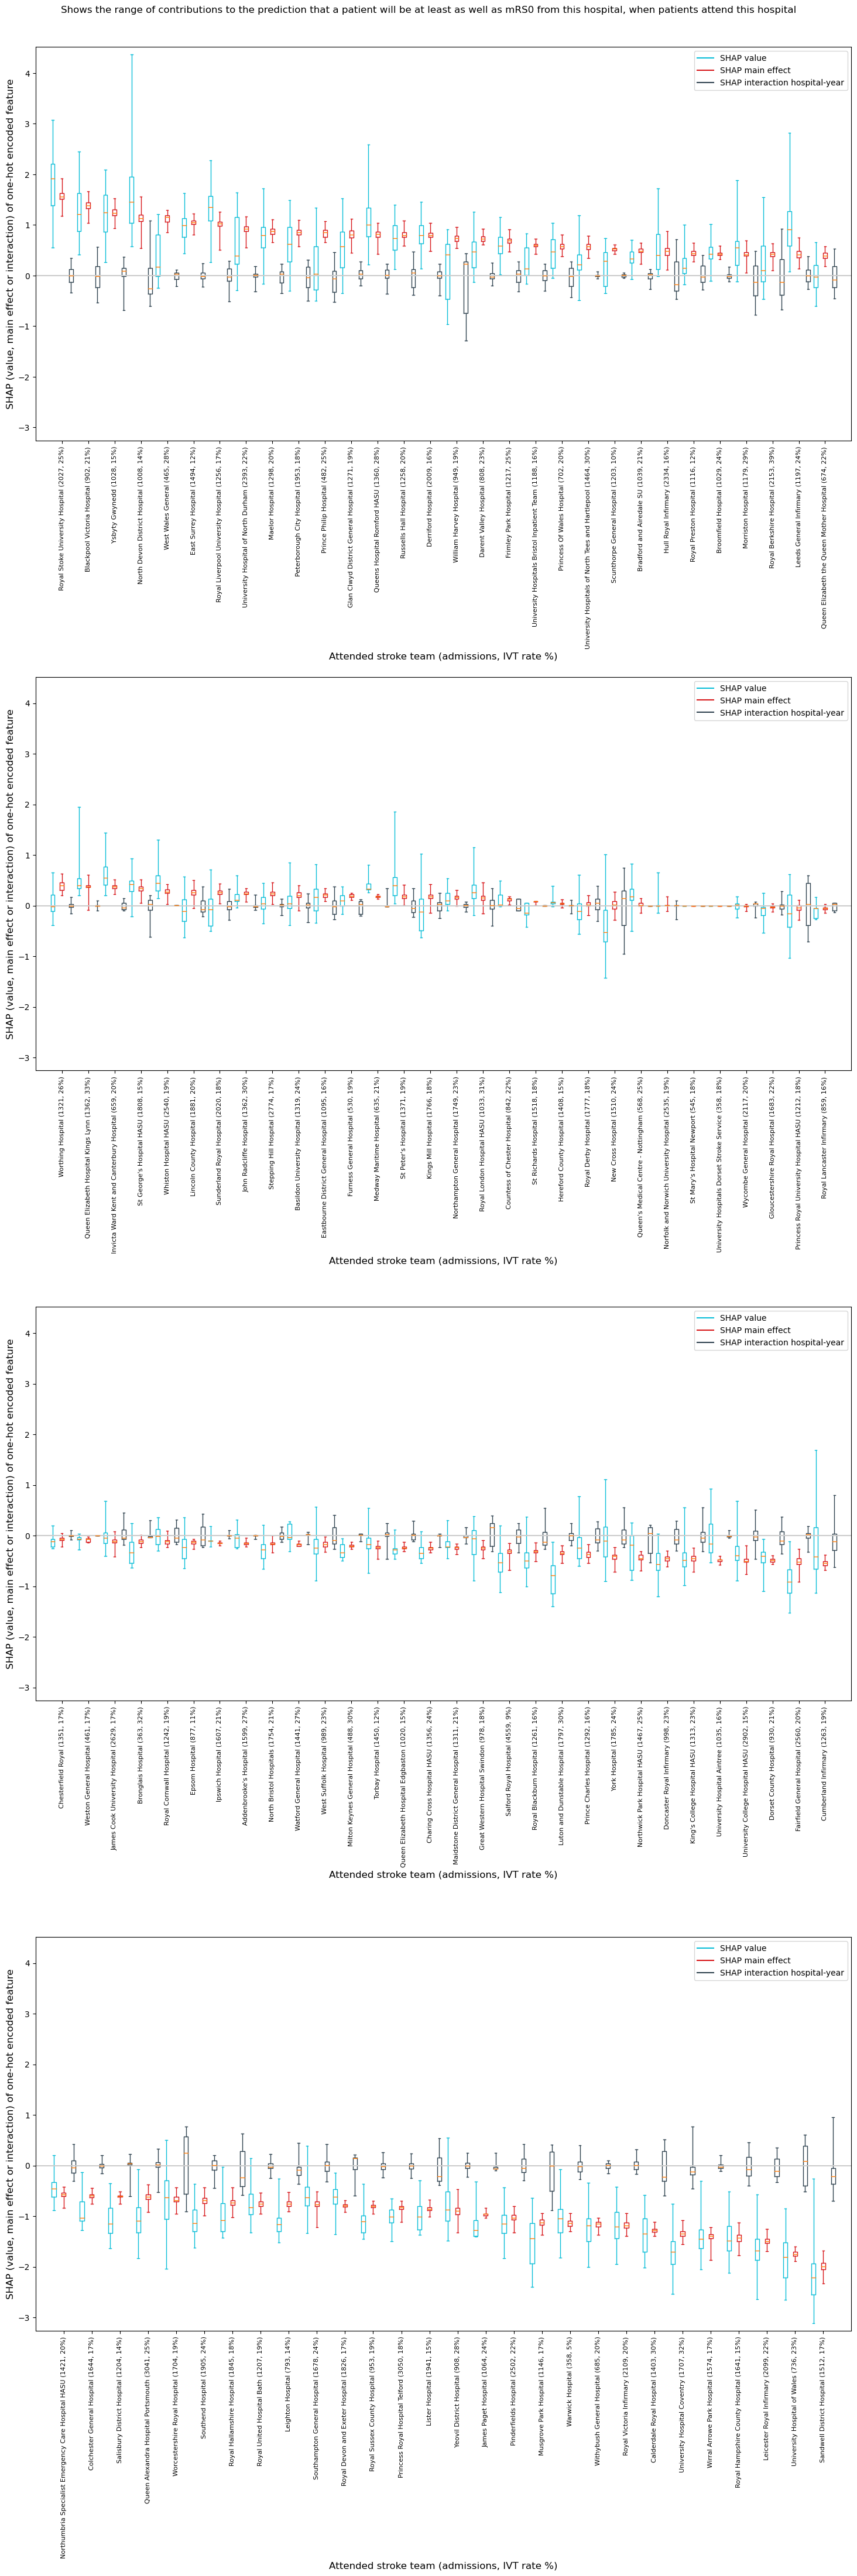

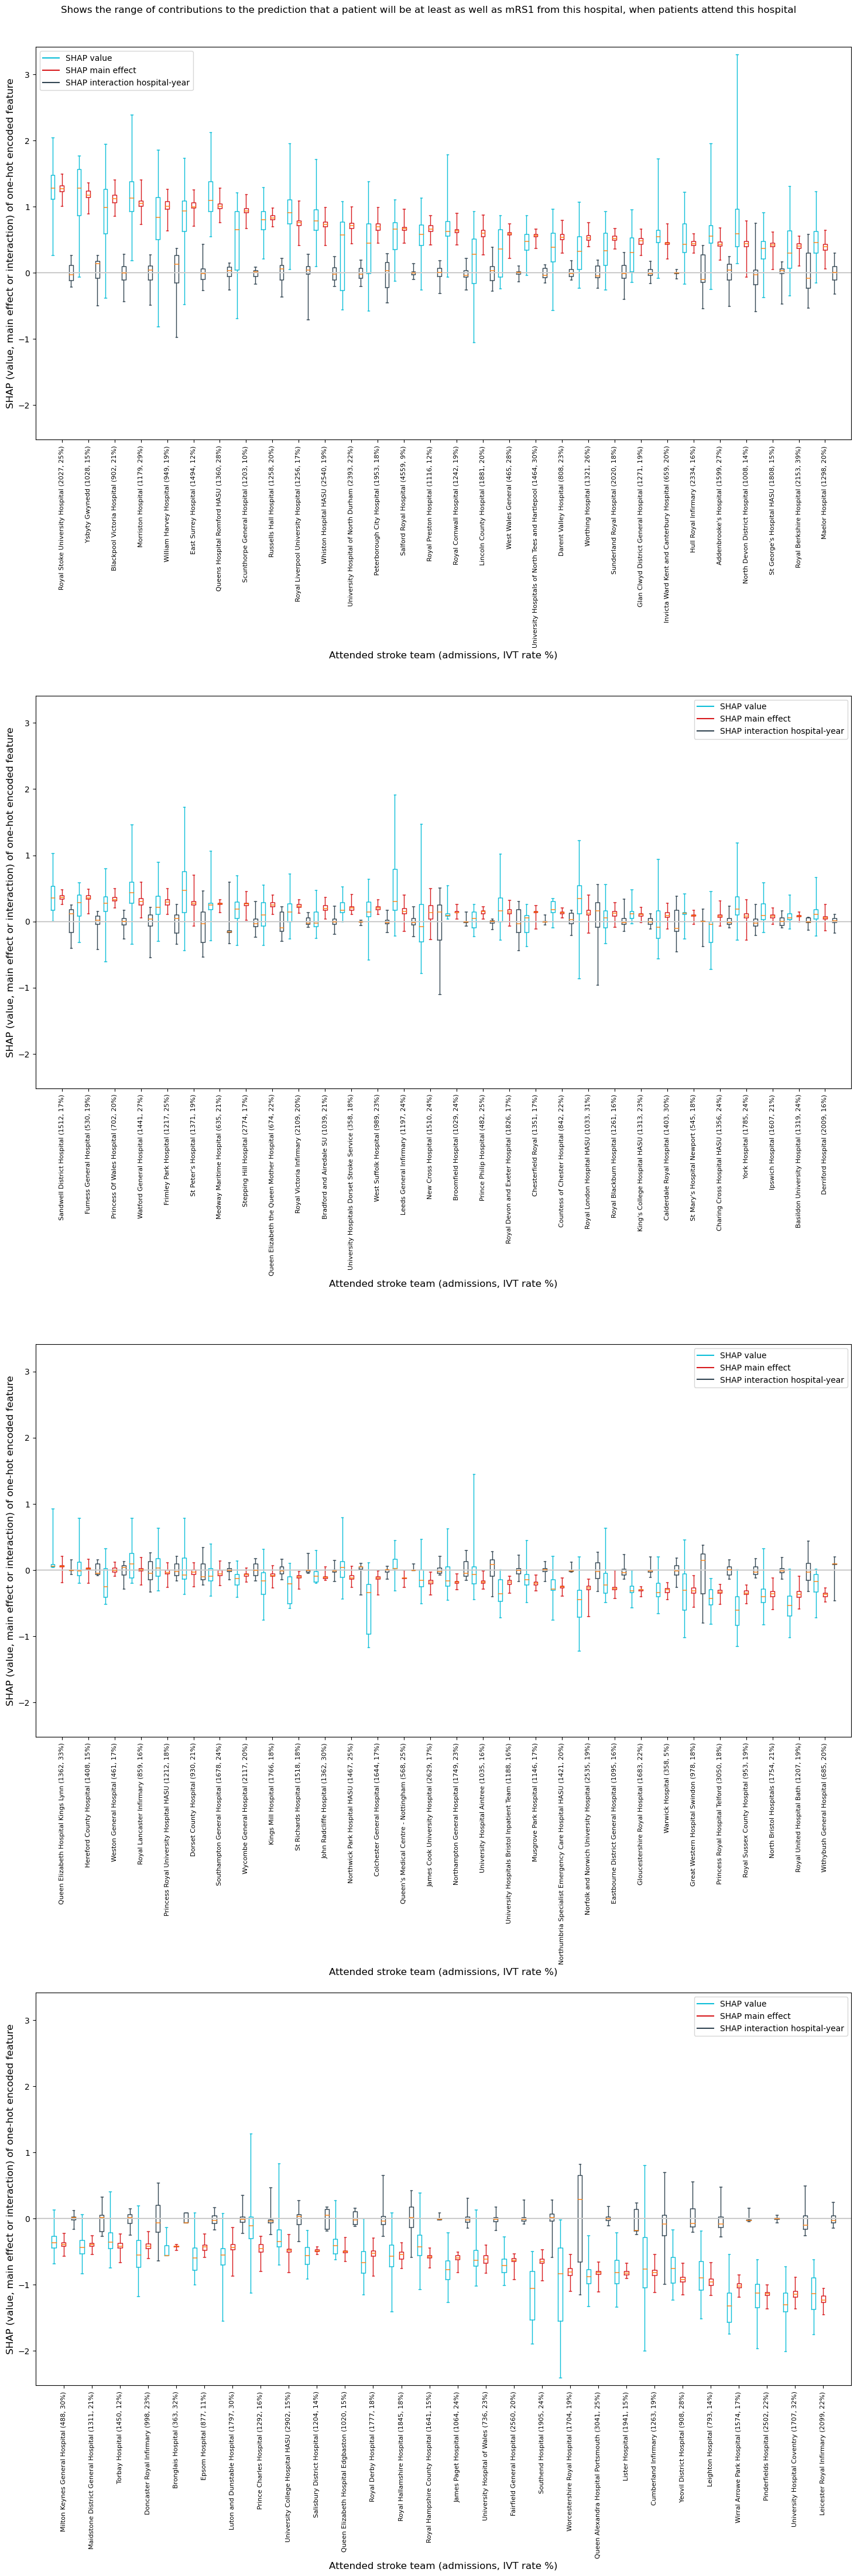

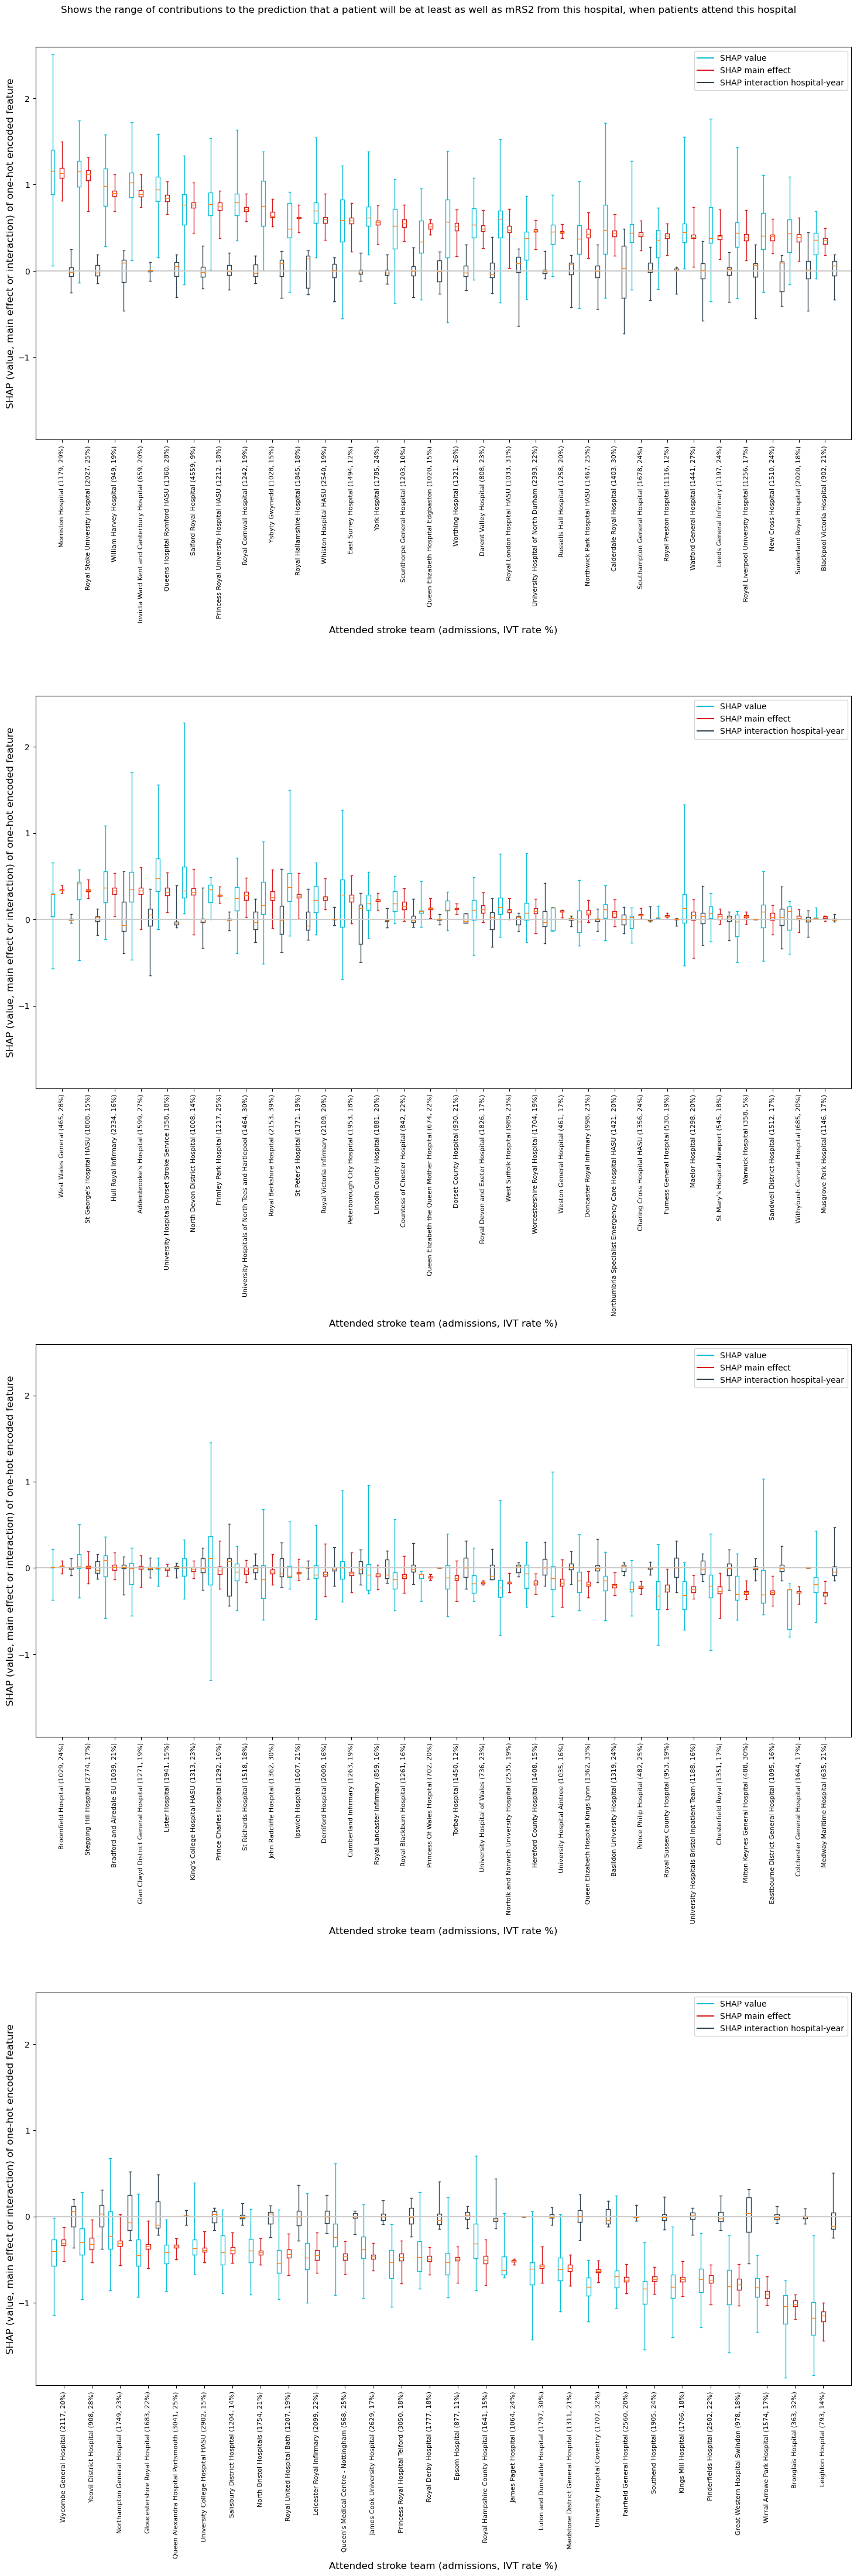

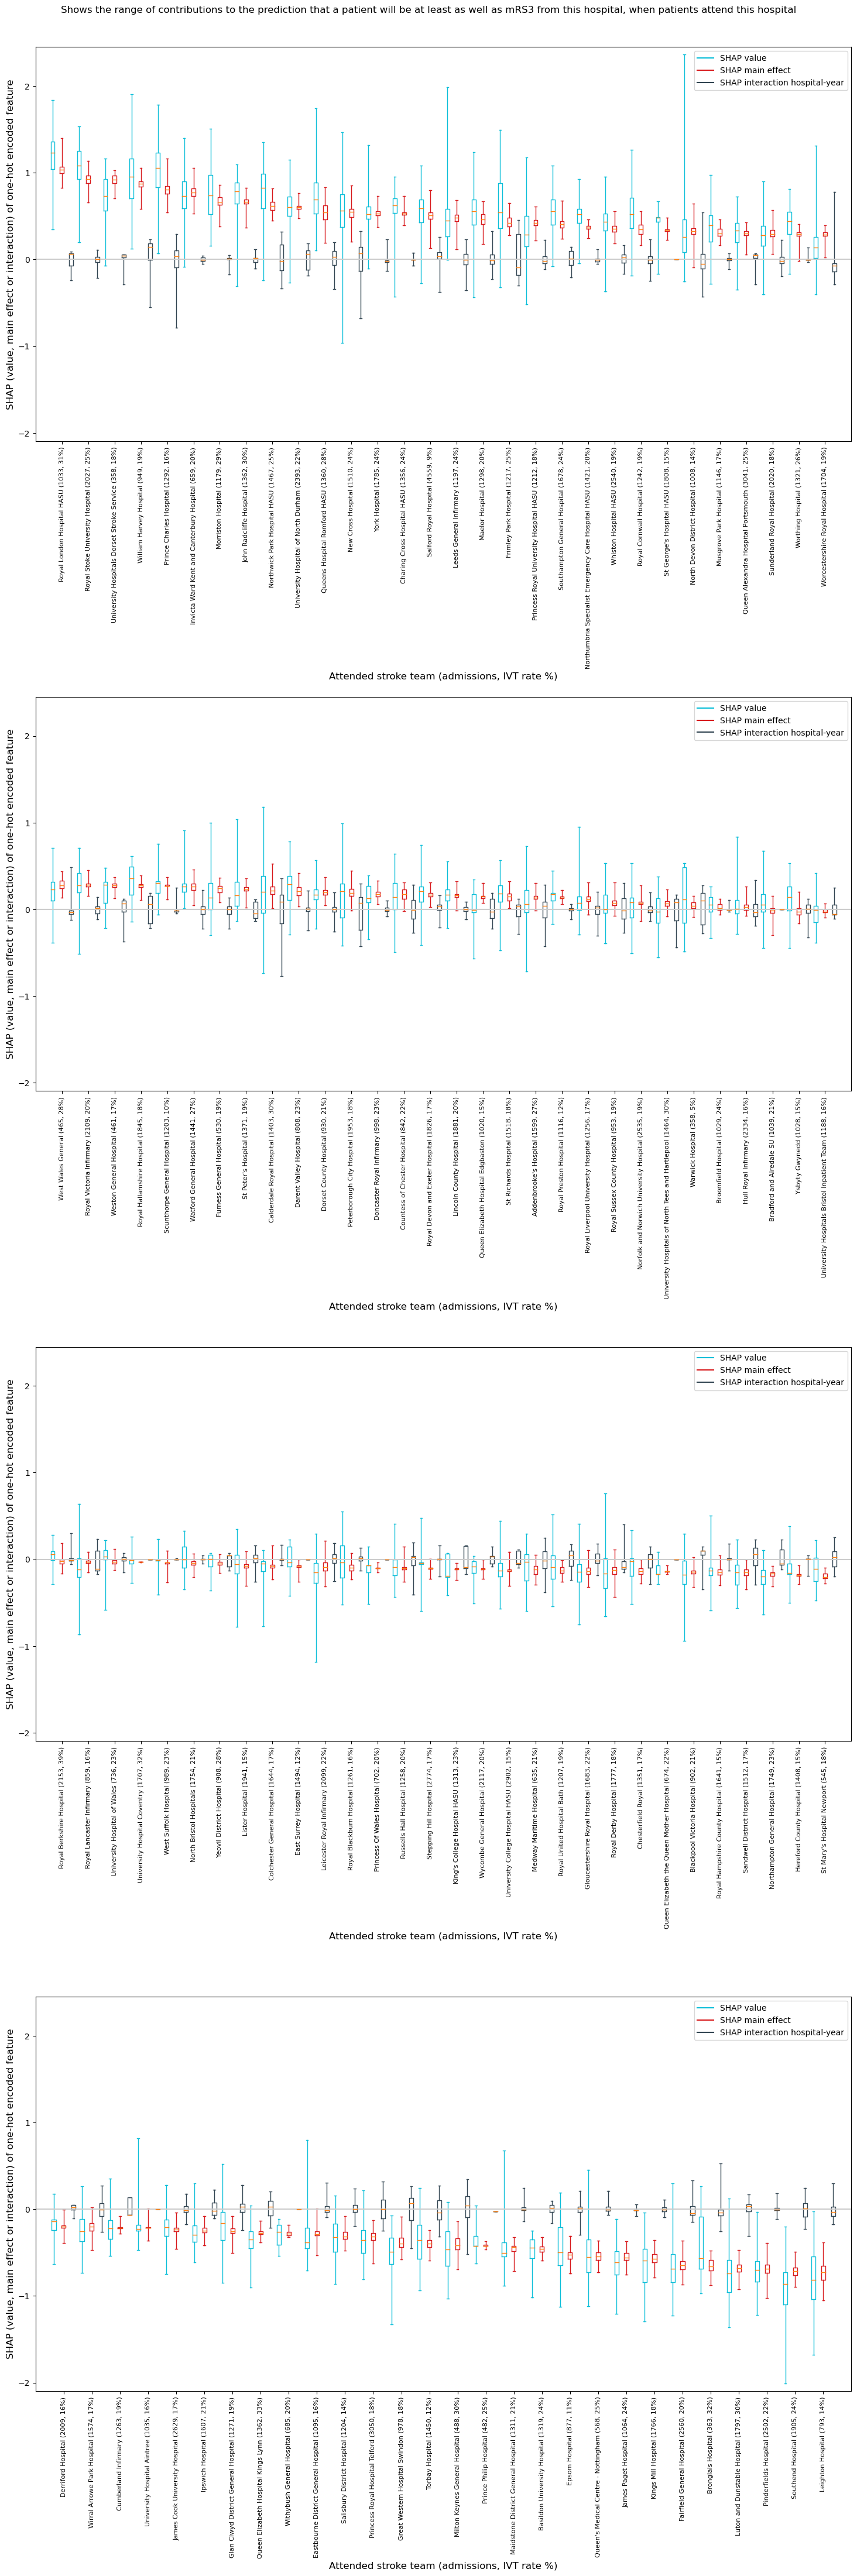

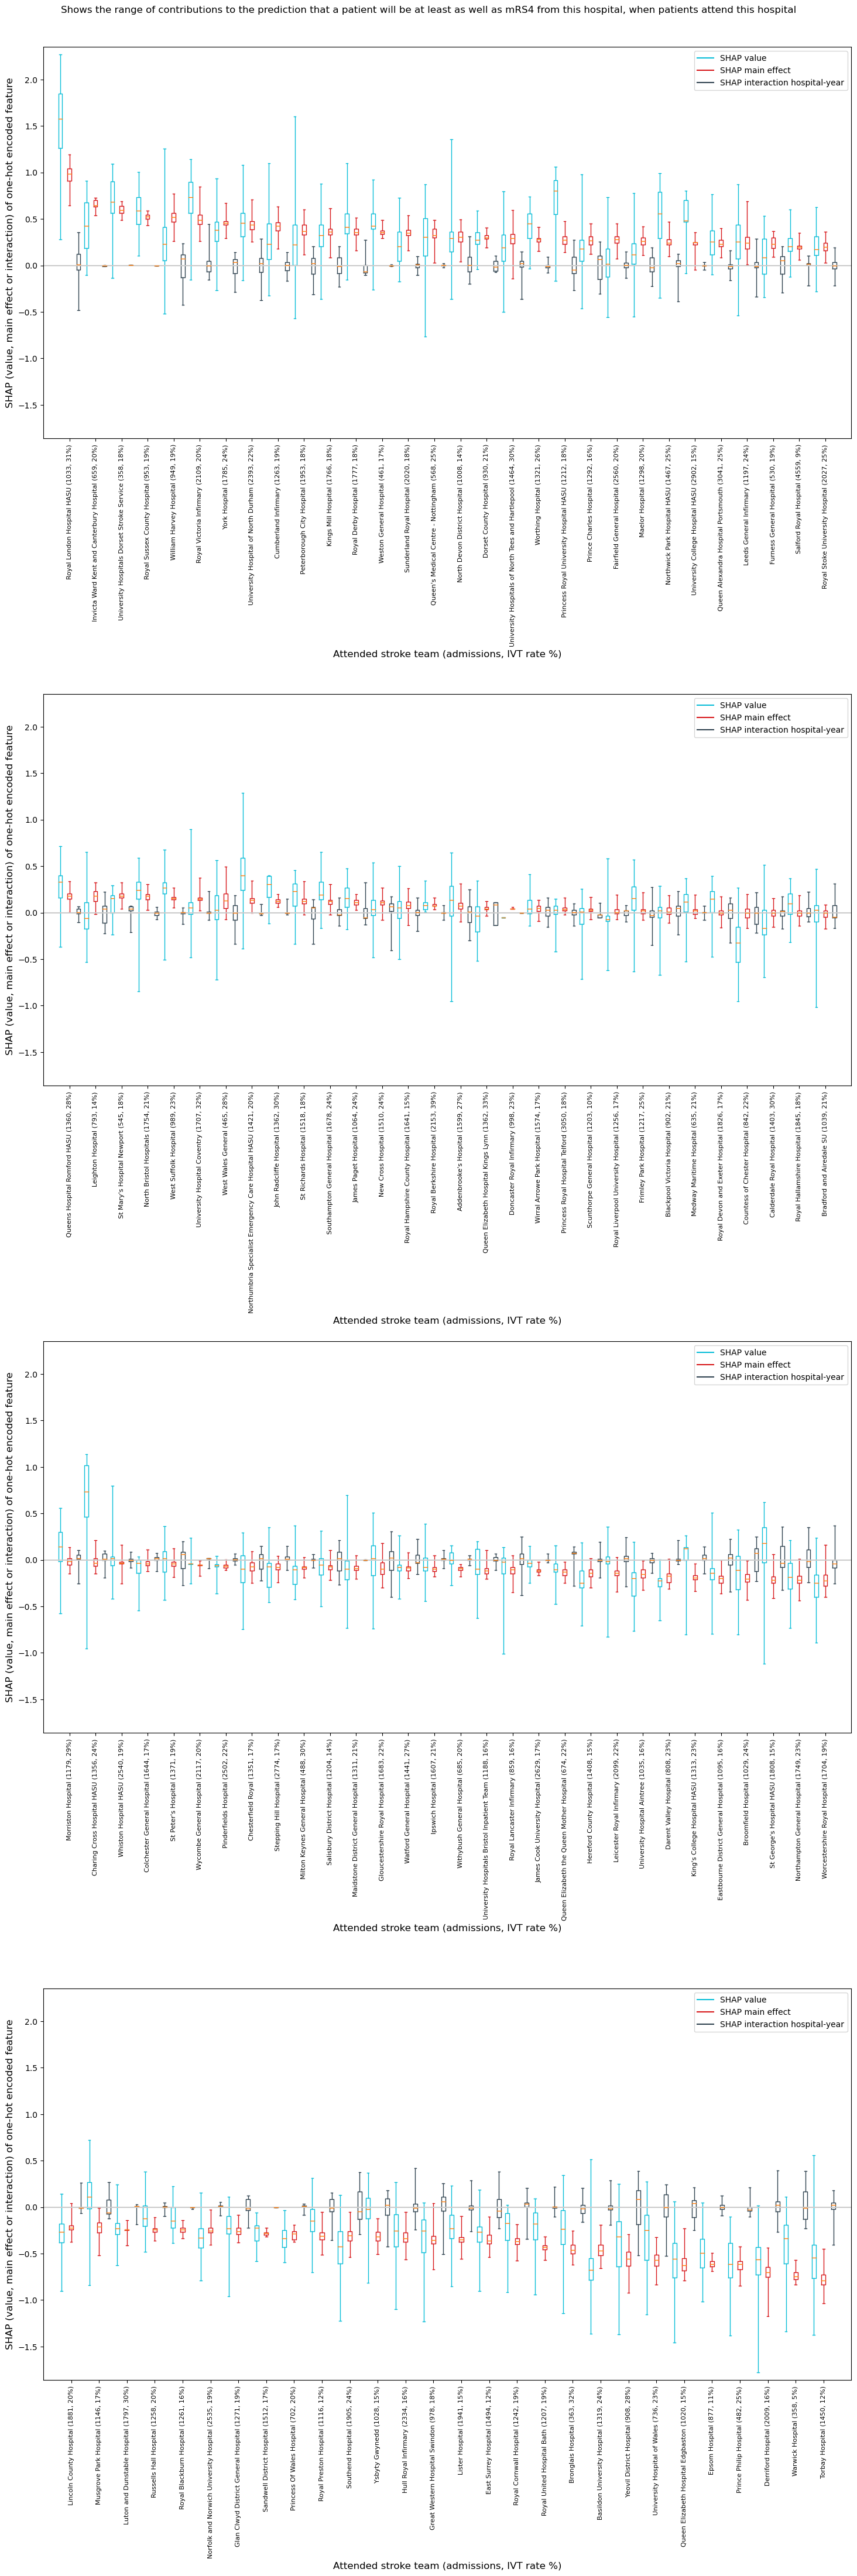

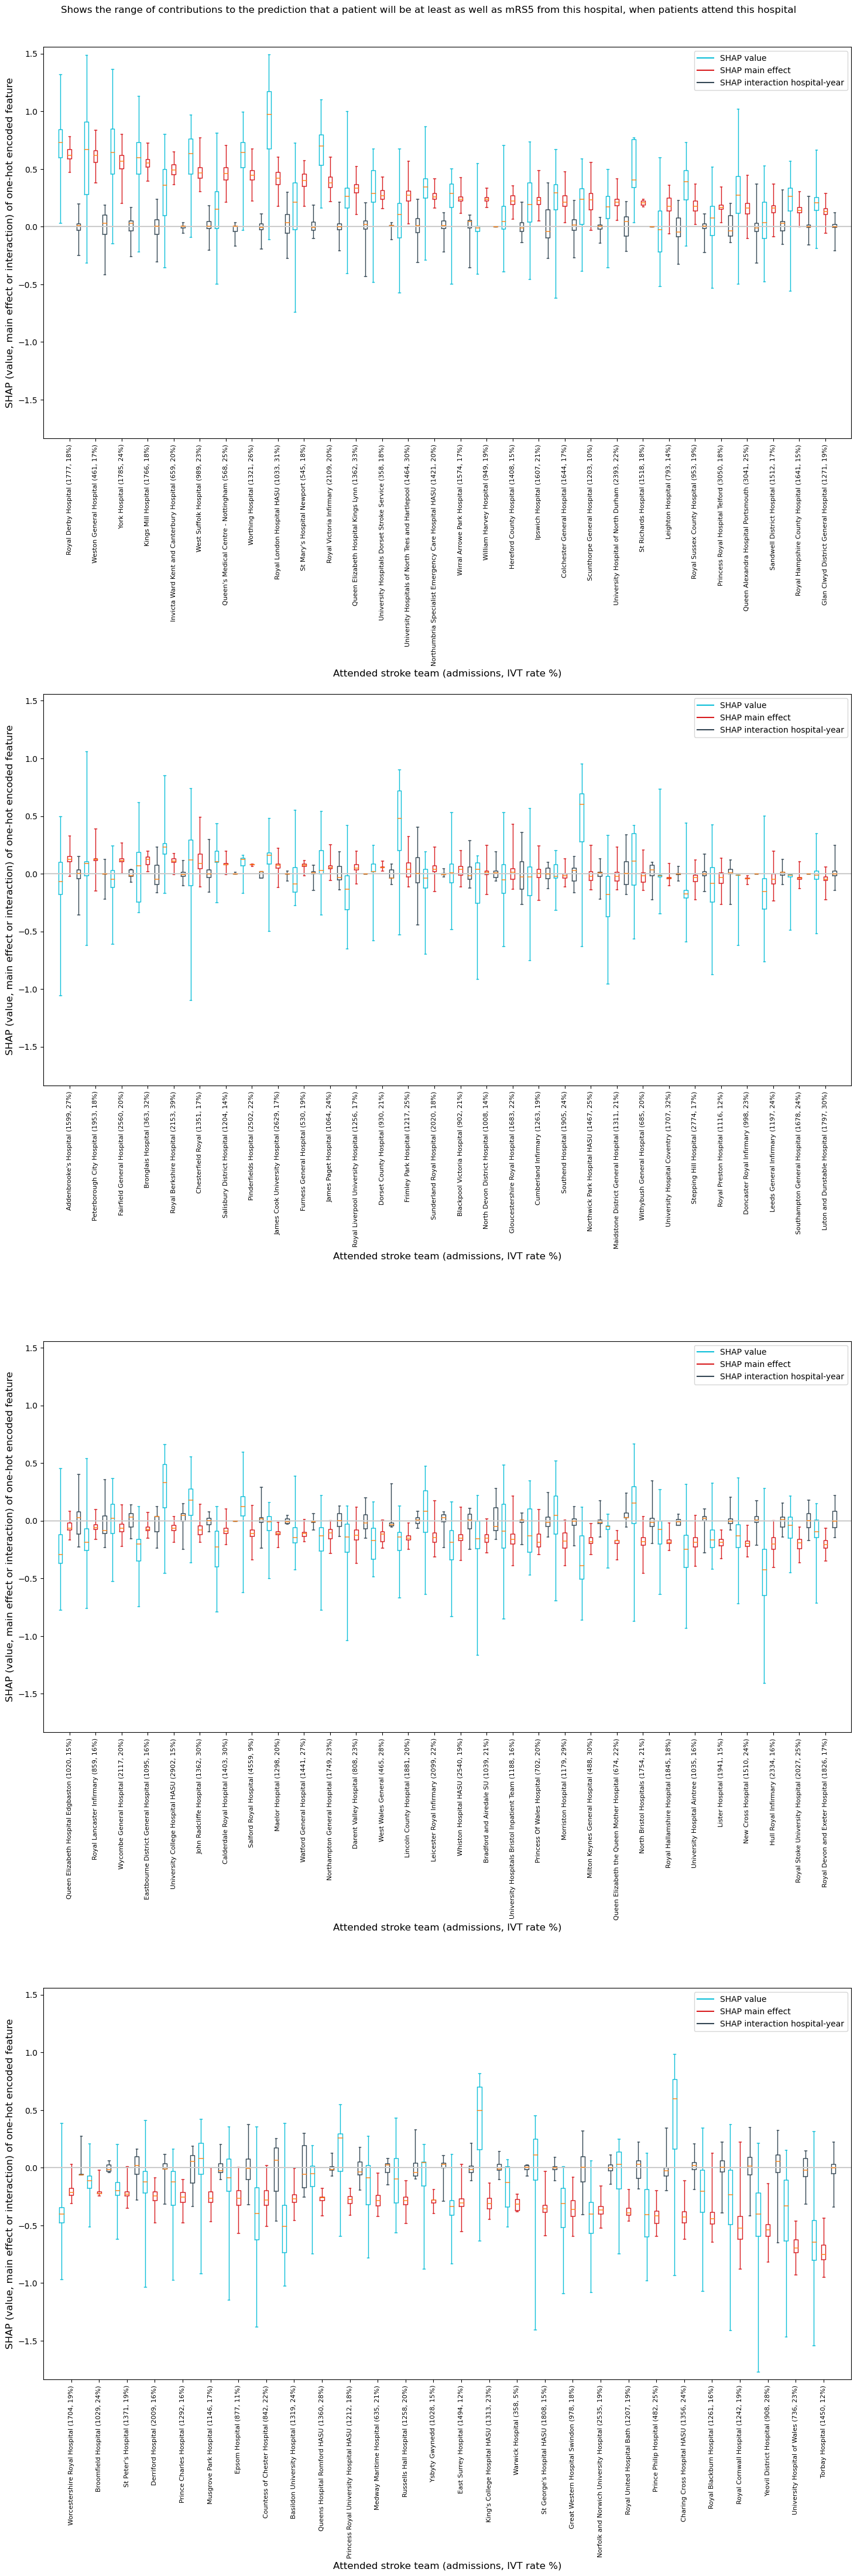

In [33]:
# For each model, get the SHAP and SHAP interaction values, create three
# dataframes, with values per patient: 
# 1) SHAP value for the hospital attended
# 2) SHAP main effect value for the hospital attended
# 3) SHAP interaction value for the hospital attended with year feature

for binary_threshold in list_binary_thresholds:

    df_hosp_shap_values = list_df_hosp_shap_values[binary_threshold]
    df_hosp_year_shap_interactions = (
                        list_df_hosp_year_shap_interactions[binary_threshold])
    df_hosp_shap_main_effects = list_df_hosp_shap_main_effects[binary_threshold]

    # Calculate the descriptive stats (IQR values) for the range of SHAP values,
    # main effect values, and interaction with year feature for the attended 
    # hospital.
    df_me = shap_descriptive_stats(hospital_names, 
                                   df_hosp_shap_main_effects, "me")
    df_sv = shap_descriptive_stats(hospital_names, 
                                   df_hosp_shap_values, "sv")
    df_ysi = shap_descriptive_stats(hospital_names, 
                                    df_hosp_year_shap_interactions, "ysi")

    # Join the three dataframes together (main effect, SHAP value, interaction)
    df_hosp_shap_descriptive_stats = df_me.join([df_sv,df_ysi])
    df_hosp_shap_descriptive_stats.drop(columns=["hospital_sv","hospital_ysi"], 
                                        inplace=True)
    df_hosp_shap_descriptive_stats.rename(columns={"hospital_me": "hospital"}, 
                                        inplace=True)
    
    # Sort in descending SHAP main effect value order
    df_hosp_shap_descriptive_stats.sort_values("shap_mean_me", 
                                           ascending=False, inplace=True) 


    # Create data for boxplot
    (me_attend_stroketeam_groups_ordered, 
     sv_attend_stroketeam_groups_ordered,
     ysi_attend_stroketeam_groups_ordered, 
     me_not_attend_stroketeam_groups_ordered,
     sv_not_attend_stroketeam_groups_ordered, 
     ysi_not_attend_stroketeam_groups_ordered, 
     xlabel) = create_data_for_hosptial_level_boxplot(
                                df_hosp_shap_descriptive_stats["hospital"], 
                                df_hosp_shap_main_effects, df_hosp_shap_values, 
                                df_hosp_year_shap_interactions,
                                df_stroketeam_ivt_adms)
    
    create_box_plot_attended_hosptial_level(
                                sv_attend_stroketeam_groups_ordered,
                                me_attend_stroketeam_groups_ordered,
                                ysi_attend_stroketeam_groups_ordered,
                                xlabel,
                                binary_threshold)